# (04) Align (within & across) -- lasso

**Motivation**: Alignment scores (using permutation importance) within and across model classes. <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# Code path
sys.path.insert(0, '/home/hadi/Documents/MTMST/code')
from vae.train_vae import TrainerVAE, ConfigTrainVAE
from vae.vae2d import VAE, ConfigVAE
from figures.fighelper import *
from analysis.glm import *


# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

## Setup

In [2]:
path = pjoin(tmp_dir, 'trainer_analysis')
pal_model, pal_cat = get_palette()

category = 'fixate1'
betas = [
    0.01, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6,
    0.7, 0.8, 0.9, 1.0, 1.5, 2.0, 5.0, 10.0,
]

files = sorted([
    f for f in os.listdir(path) if category in f
    and any(f"beta-{b}" in f for b in betas)
])
print(files)

[
    'fixate1_nf-420_beta-0.01_(2023_04_30,07:42).npy',
    'fixate1_nf-420_beta-0.15_(2023_04_27,20:20).npy',
    'fixate1_nf-420_beta-0.1_(2023_04_29,22:01).npy',
    'fixate1_nf-420_beta-0.2_(2023_04_30,21:37).npy',
    'fixate1_nf-420_beta-0.3_(2023_05_07,01:03).npy',
    'fixate1_nf-420_beta-0.4_(2023_05_07,02:37).npy',
    'fixate1_nf-420_beta-0.5_(2023_04_30,20:05).npy',
    'fixate1_nf-420_beta-0.6_(2023_04_30,20:36).npy',
    'fixate1_nf-420_beta-0.7_(2023_04_30,21:40).npy',
    'fixate1_nf-420_beta-0.8_(2023_05_07,04:15).npy',
    'fixate1_nf-420_beta-0.8_(2023_05_13,14:52).npy',
    'fixate1_nf-420_beta-0.9_(2023_05_07,05:51).npy',
    'fixate1_nf-420_beta-1.0_(2023_04_29,19:41).npy',
    'fixate1_nf-420_beta-1.5_(2023_05_08,14:55).npy',
    'fixate1_nf-420_beta-10.0_(2023_04_30,22:48).npy',
    'fixate1_nf-420_beta-2.0_(2023_05_07,07:27).npy',
    'fixate1_nf-420_beta-5.0_(2023_05_07,08:59).npy',
    'vanilla_fixate1_nf-420_beta-0.01_(2023_05_13,21:48).npy',
    'vanilla_fixate1_nf-420_beta-0.15_(2023_05_02,15:15).npy',
    'vanilla_fixate1_nf-420_beta-0.1_(2023_05_10,21:14).npy',
    'vanilla_fixate1_nf-420_beta-0.2_(2023_05_10,23:41).npy',
    'vanilla_fixate1_nf-420_beta-0.3_(2023_05_13,07:46).npy',
    'vanilla_fixate1_nf-420_beta-0.4_(2023_05_11,19:25).npy',
    'vanilla_fixate1_nf-420_beta-0.5_(2023_05_07,02:51).npy',
    'vanilla_fixate1_nf-420_beta-0.6_(2023_05_12,18:12).npy',
    'vanilla_fixate1_nf-420_beta-0.7_(2023_05_12,08:53).npy',
    'vanilla_fixate1_nf-420_beta-0.8_(2023_05_11,02:19).npy',
    'vanilla_fixate1_nf-420_beta-0.9_(2023_05_13,20:45).npy',
    'vanilla_fixate1_nf-420_beta-1.0_(2023_05_07,01:18).npy',
    'vanilla_fixate1_nf-420_beta-1.5_(2023_05_14,14:16).npy',
    'vanilla_fixate1_nf-420_beta-10.0_(2023_05_09,09:59).npy',
    'vanilla_fixate1_nf-420_beta-2.0_(2023_05_09,08:19).npy',
    'vanilla_fixate1_nf-420_beta-5.0_(2023_05_15,07:23).npy'
]

In [3]:
%%time

kl_diag = {}
z_vld, z_tst = {}, {}

for f in files:
    x = pjoin(path, f)
    x = np.load(x, allow_pickle=True).item()
    z_vld[f] = x['data_vld']['z']
    z_tst[f] = x['data_tst']['z']
    kl_diag[f] = x['loss']['kl_diag']

CPU times: user 14.4 s, sys: 3min 54s, total: 4min 8s
Wall time: 5min 8s


## All pairwise

In [ ]:
%%time

thres = 1e-3
looper = itertools.combinations(files, 2)

df = []
for f1, f2 in tqdm(looper, total=int(len(files) * (len(files) - 1) / 2)):
    for src, tgt in [(f1, f2), (f2, f1)]:
        *_, beta1, model1 = extract_info(src)
        *_, beta2, model2 = extract_info(tgt)

        x_vld, y_vld = z_vld[src], z_vld[tgt]
        x_tst, y_tst = z_tst[src], z_tst[tgt]
        # x_active = kl_diag[src] > thres
        y_active = kl_diag[tgt] > thres

        # zscore
        x_mu = x_vld.mean(0, keepdims=True)
        y_mu = y_vld.mean(0, keepdims=True)
        x_sd = x_vld.std(0, keepdims=True)
        y_sd = y_vld.std(0, keepdims=True)
        x_vld = normalize_global(x_vld, x_mu, x_sd)
        x_tst = normalize_global(x_tst, x_mu, x_sd)
        y_vld = normalize_global(y_vld, y_mu, y_sd)
        y_tst = normalize_global(y_tst, y_mu, y_sd)

        # fit lasso
        lasso = sk_linear.Lasso(
            alpha=0.02,
            random_state=0,
        ).fit(x_vld, y_vld[:, y_active])
        pred = lasso.predict(x_tst)

        # r2 score
        r2 = sk_metric.r2_score(
            y_pred=pred,
            y_true=y_tst[:, y_active],
            multioutput='raw_values',
        )

        # alignment
        w = np.abs(lasso.coef_)
        a = 1 - entropy_normalized(w, axis=w.ndim - 1)

        df.append({
            'src': [model1] * y_active.sum(),
            'tgt': [model2] * y_active.sum(),
            'cond': [
                'within' if model1 == model2 else
                'across'] * y_active.sum(),
            'beta_src': [beta1] * y_active.sum(),
            'beta_tgt': [beta2] * y_active.sum(),
            'active_tgt': np.where(y_active)[0],
            'r2': list(r2),
            'a': [a] if isinstance(a, float) else a,
        })
df = pd.DataFrame(merge_dicts(df))

  0%|                                                   | 0/528 [00:00<?, ?it/s]/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.480e+00, tolerance: 7.500e+00
  model = cd_fast.enet_coordinate_descent(
  0%|                                       | 1/528 [03:29<30:38:50, 209.36s/it]/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.454e+01, tolerance: 7.500e+00
  model = cd_fast.enet_coordinate_descent(
  0%|▏                                      | 2/528 [07:07<31:18:47, 214.31s/it]/home/hadi/anaconda3/lib/python3.8/site-pack

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.581e+01, tolerance: 7.500e+00
  model = cd_fast.enet_coordinate_descent(
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.938e+01, tolerance: 7.500e+00
  model = cd_fast.enet_coordinate_descent(
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1

 18%|██████▍                             | 95/528 [2:49:03<16:11:44, 134.65s/it]/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.958e+00, tolerance: 7.500e+00
  model = cd_fast.enet_coordinate_descent(
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.628e+00, tolerance: 7.500e+00
  model = cd_fast.enet_coordinate_descent(
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.920e+00, tolerance: 7.500e+00
  model = cd_fast.enet_coordinate_descent(
 23%|████████▏                          | 124/528 [3:42:12<14:09:07, 126.11s/it]/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.327e+00, tolerance: 7.500e+00
  model = cd_fast.enet_coordinate_descent(
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.228e+01, tolerance: 7.500e+00
  model = cd_fast.enet_coordinate_descent(
 29%|██████████▏                        | 153/528 [4:22:12<12:16:04, 117.77s/it]/home/hadi/anaconda3/lib/python3.8/site-packages/scipy/stats/_entropy.py:135: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.508e+01, tolerance: 7.500e+00
  model = cd_fast.enet_coordinate_descent(
 29%|██████████▏

 35%|█████████████                        | 186/528 [5:03:56<8:14:16, 86.71s/it]/home/hadi/anaconda3/lib/python3.8/site-packages/scipy/stats/_entropy.py:135: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.285e+01, tolerance: 7.500e+00
  model = cd_fast.enet_coordinate_descent(
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.967e+00, tolerance: 7.500e+00
  model = cd_fast.enet_coordinate_descent(
 38%|███████████

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.646e+00, tolerance: 7.500e+00
  model = cd_fast.enet_coordinate_descent(
/home/hadi/anaconda3/lib/python3.8/site-packages/scipy/stats/_entropy.py:135: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
 48%|█████████████████▊                   | 255/528 [6:10:20<4:56:02, 65.07s/it]/home/hadi/anaconda3/lib/python3.8/site-packages/scipy/stats/_entropy.py:135: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
 48%|█████████████████▉                   | 256/528 [6:11:25<4:54:58, 65.07s/it]/home/hadi/anaconda3/lib/python3.8/site-packages/scipy/stats/_entropy.py:135: RuntimeWarning: invalid valu

 52%|███████████████████▍                 | 277/528 [6:23:39<2:44:09, 39.24s/it]/home/hadi/anaconda3/lib/python3.8/site-packages/scipy/stats/_entropy.py:135: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
 53%|███████████████████▌                 | 279/528 [6:24:30<2:07:02, 30.61s/it]/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.028e+01, tolerance: 7.500e+00
  model = cd_fast.enet_coordinate_descent(
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.169e+01, 

 64%|███████████████████████▊             | 340/528 [6:49:15<1:22:53, 26.45s/it]/home/hadi/anaconda3/lib/python3.8/site-packages/scipy/stats/_entropy.py:135: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.749e+01, tolerance: 7.500e+00
  model = cd_fast.enet_coordinate_descent(
/home/hadi/anaconda3/lib/python3.8/site-packages/scipy/stats/_entropy.py:135: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
 65%|███████████████████████▉             | 341/528 [6:49:42<1:22:41, 26.53s/it]/home/hadi/anaconda3/lib/python3.8/site-packages/scipy/stats/_entropy.py:135: RuntimeWarning: invalid valu

 73%|████████████████████████████▌          | 387/528 [7:01:03<44:21, 18.87s/it]/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.821e+00, tolerance: 7.500e+00
  model = cd_fast.enet_coordinate_descent(
 73%|████████████████████████████▋          | 388/528 [7:01:20<42:59, 18.43s/it]/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.299e+01, tolerance: 7.500e+00
  model = cd_fast.enet_coordinate_descent(
 74%|████████████████████████████▉          | 392/528 [7:02:43<45:29, 20.07s/it]/home/hadi/anaconda3/lib/python3.8/site-pack

/home/hadi/anaconda3/lib/python3.8/site-packages/scipy/stats/_entropy.py:135: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
 78%|██████████████████████████████▌        | 413/528 [7:09:07<29:46, 15.53s/it]/home/hadi/anaconda3/lib/python3.8/site-packages/scipy/stats/_entropy.py:135: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
 78%|██████████████████████████████▌        | 414/528 [7:09:20<28:16, 14.88s/it]/home/hadi/anaconda3/lib/python3.8/site-packages/scipy/stats/_entropy.py:135: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
 79%|██████████████████████████████▋        | 415/528 [7:09:41<31:16, 16.60s/it]/home/hadi/anaconda3/lib/python3.8/site-packages/scipy/stats/_entropy.py:135: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
 79%|███

TypeError: 'numpy.float64' object is not iterable

In [18]:
df_fixed = []

for item in df:
    item_fixed = {}
    for k, v in item.items():
        if isinstance(v, float):
            item_fixed[k] = [v]
        else:
            item_fixed[k] = v
    df_fixed.append(item_fixed)

df_fixed = pd.DataFrame(merge_dicts(df_fixed))

In [19]:
_ = save_obj(obj=df_fixed, file_name='df_lasso', save_dir=tmp_dir, mode='df')

[PROGRESS] 'df_lasso.df' saved at
/home/hadi/Dropbox/git/jb-MTMST/tmp

In [21]:
df_mean  = df_fixed.groupby([
    'src', 'tgt', 'beta_src', 'beta_tgt',
]).mean().reset_index()

df_mean

,src,tgt,beta_src,beta_tgt,active_tgt,r2,a
0,VAE,VAE,0.01,0.10,137.833333,0.770830,0.529696
1,VAE,VAE,0.01,0.15,205.777778,0.682630,0.518456
2,VAE,VAE,0.01,0.20,148.941176,0.655409,0.515293
3,VAE,VAE,0.01,0.30,174.076923,0.655608,0.536334
4,VAE,VAE,0.01,0.40,145.285714,0.551973,0.515124
...,...,...,...,...,...,...,...
988,cNVAE,cNVAE,10.00,0.90,265.153846,0.706500,0.530710
989,cNVAE,cNVAE,10.00,1.00,230.705882,0.641408,0.520348
990,cNVAE,cNVAE,10.00,1.50,217.538462,0.575708,0.513192
991,cNVAE,cNVAE,10.00,2.00,233.222222,0.736046,0.511236


In [23]:
df_median  = df_fixed.groupby([
    'src', 'tgt', 'beta_src', 'beta_tgt',
]).median().reset_index()

df_median

,src,tgt,beta_src,beta_tgt,active_tgt,r2,a
0,VAE,VAE,0.01,0.10,131.0,0.799809,0.519251
1,VAE,VAE,0.01,0.15,227.5,0.690755,0.510229
2,VAE,VAE,0.01,0.20,151.0,0.702102,0.513355
3,VAE,VAE,0.01,0.30,169.0,0.601019,0.496387
4,VAE,VAE,0.01,0.40,160.0,0.416246,0.494298
...,...,...,...,...,...,...,...
988,cNVAE,cNVAE,10.00,0.90,272.0,0.771011,0.517792
989,cNVAE,cNVAE,10.00,1.00,257.0,0.820433,0.505035
990,cNVAE,cNVAE,10.00,1.50,194.0,0.722679,0.515887
991,cNVAE,cNVAE,10.00,2.00,243.0,0.736103,0.514670


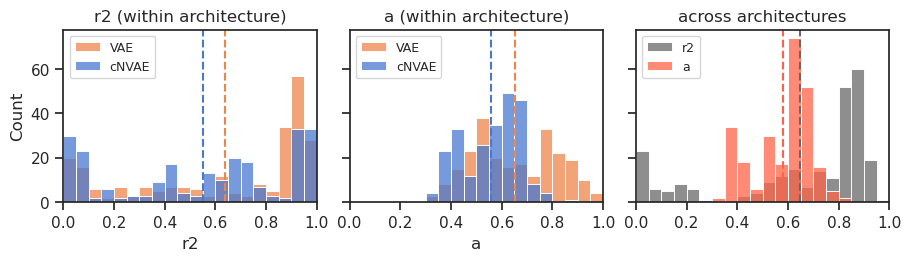

In [26]:
fig, axes = create_figure(1, 3, (9, 2.5), 'all', 'all', 'constrained')
for i, k in enumerate(['r2', 'a']):
    for mod in ['VAE', 'cNVAE']:
        _df_within = df_median.loc[
            (df_median['src'] == mod) &
            (df_median['tgt'] == mod) 
        ]
        x2p = _df_within[k]
        sns.histplot(
            x2p,
            color=pal_model[mod],
            bins=np.linspace(0, 1, 21),
            label=mod,
            ax=axes[i],
        )
        axes[i].axvline(x2p.mean(), color=pal_model[mod], ls='--')
        axes[i].set_title(f"{k} (within architecture)")
        axes[i].legend(fontsize=9)

_df_across = df_median.loc[
    (df_median['src'] == 'cNVAE') &
    (df_median['tgt'] == 'VAE') 
]
for k, c in [('r2', 'dimgrey'), ('a', 'tomato')]:
    x2p = _df_across[k]
    sns.histplot(
        x2p,
        color=c,
        label=k,
        bins=np.linspace(0, 1, 21),
        ax=axes[-1],
    )
    axes[-1].axvline(x2p.mean(), color=c, ls='--')
axes[-1].set_title('across architectures')
axes[-1].legend(fontsize=9)
axes[-1].set_xlim(0, 1)
axes[-1].set_xlabel('')
plt.show()

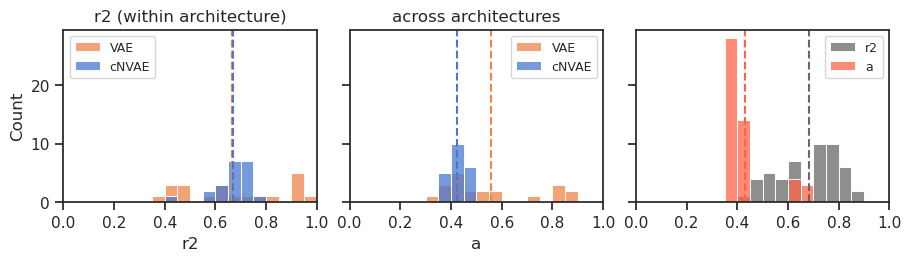

In [27]:
df_median

,src,tgt,beta_src,beta_tgt,active_tgt,r2,a
0,VAE,VAE,0.01,0.10,131.0,0.799809,0.519251
1,VAE,VAE,0.01,0.15,227.5,0.690755,0.510229
2,VAE,VAE,0.01,0.20,151.0,0.702102,0.513355
3,VAE,VAE,0.01,0.30,169.0,0.601019,0.496387
4,VAE,VAE,0.01,0.40,160.0,0.416246,0.494298
...,...,...,...,...,...,...,...
988,cNVAE,cNVAE,10.00,0.90,272.0,0.771011,0.517792
989,cNVAE,cNVAE,10.00,1.00,257.0,0.820433,0.505035
990,cNVAE,cNVAE,10.00,1.50,194.0,0.722679,0.515887
991,cNVAE,cNVAE,10.00,2.00,243.0,0.736103,0.514670


In [140]:
mod_pair = ('cNVAE', 'VAE')
beta_pair = (0.15, 0.20)

d2p = []
for k in ['r2', 'a']:
    for mod in mod_pair:
        v = np.concatenate([
            _collect_vals(k, mod, mod, *beta_pair),
            _collect_vals(k, mod, mod, *beta_pair[::-1]),
        ])
        d2p.append({
            'cond': ['within'] * len(v),
            'model': [mod] * len(v),
            'k': [k] * len(v),
            'v': v,
        })
    v = np.concatenate([
        _collect_vals(k, *mod_pair, beta_pair[0], beta_pair[0]),
        _collect_vals(k, *mod_pair, beta_pair[1], beta_pair[1]),
        
        _collect_vals(k, *mod_pair[::-1], beta_pair[0], beta_pair[0]),
        _collect_vals(k, *mod_pair[::-1], beta_pair[1], beta_pair[1]),
        
        _collect_vals(k, *mod_pair, *beta_pair),
        _collect_vals(k, *mod_pair, *beta_pair[::-1]),
        
        _collect_vals(k, *mod_pair[::-1], *beta_pair),
        _collect_vals(k, *mod_pair[::-1], *beta_pair[::-1]),
    ])
    d2p.append({
        'cond': ['across'] * len(v),
        'model': [None] * len(v),
        'k': [k] * len(v),
        'v': v,
    })
d2p = pd.DataFrame(merge_dicts(d2p))

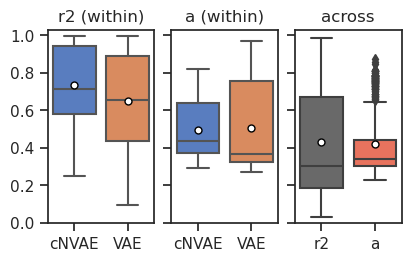

In [164]:
_pal = {
    m: pal_model.get(m) for
    m in ['cNVAE', 'VAE']
}
fig, axes = create_figure(1, 3, (4, 2.5), sharey='all', layout='constrained')
for i, k in enumerate(['r2', 'a']):
    ax = axes.flat[i]
    ax.set_title(f'{k} (within)')
    sns.boxplot(
        data=d2p.loc[
            (d2p['k'] == k) &
            (d2p['cond'] == 'within')],
        x='model',
        y='v',
        hue='model',
        order=_pal,
        palette=_pal,
        dodge=False,
        showmeans=True,
        meanprops={
            'marker': 'o',
            'markerfacecolor': 'white',
            'markeredgecolor': 'k',
            'markersize': 5,
            'alpha': 1.0},
        ax=ax,
    )
    ax.set(xlabel='', ylabel='')
    leg = ax.get_legend()
    leg.remove()
    
_pal = {
    'r2': 'dimgrey',
    'a': 'tomato',
}
ax = axes.flat[-1]
ax.set_title('across')
sns.boxplot(
    data=d2p.loc[d2p['cond'] == 'across'],
    x='k',
    y='v',
    hue='k',
    order=_pal,
    palette=_pal,
    dodge=False,
    showmeans=True,
    meanprops={
        'marker': 'o',
        'markerfacecolor': 'white',
        'markeredgecolor': 'k',
        'markersize': 5,
        'alpha': 1.0},
    ax=ax,
)
ax.set(xlabel='', ylabel='')
leg = ax.get_legend()
leg.remove()
axes[-1].set_ylim(0, 1.03)
plt.show()

In [235]:
def _collect_vals(k, m1, m2, b1, b2):
    return df_fixed.loc[
        (df_fixed['src'] == m1) &
        (df_fixed['tgt'] == m2) &
        (df_fixed['beta_src'] == b1) &
        (df_fixed['beta_tgt'] == b2),
        k
    ].values


def _get_d2p(m1, m2, beta_pair):
    d2p = []
    mod_pair = (m1, m2)
    for k in ['r2', 'a']:
        for m in mod_pair:
            v = np.concatenate([
                _collect_vals(k, m, m, *beta_pair),
                _collect_vals(k, m, m, *beta_pair[::-1]),
            ])
            d2p.append({
                'cond': [f"within ({m} -> {m})"] * len(v),
                'k': [k] * len(v),
                'v': v,
            })
        # across: m1 -> m2
        v = np.concatenate([
            _collect_vals(k, m1, m2, beta_pair[0], beta_pair[0]),
            _collect_vals(k, m1, m2, beta_pair[1], beta_pair[1]),
            # _collect_vals(k, m1, m2, *beta_pair),
            # _collect_vals(k, m1, m2, *beta_pair[::-1]),
        ])
        d2p.append({
            'cond': [f'across ({m1} -> {m2})'] * len(v),
            'k': [k] * len(v),
            'v': v,
        })
        # across: m2 -> m1
        v = np.concatenate([
            _collect_vals(k, m2, m1, beta_pair[0], beta_pair[0]),
            _collect_vals(k, m2, m1, beta_pair[1], beta_pair[1]),
            # _collect_vals(k, m1, m2, *beta_pair),
            # _collect_vals(k, m1, m2, *beta_pair[::-1]),
        ])
        d2p.append({
            'cond': [f'across ({m2} -> {m1})'] * len(v),
            'k': [k] * len(v),
            'v': v,
        })
    d2p = pd.DataFrame(merge_dicts(d2p))
    return d2p


def _show(d2p, figsize=(3, 4), display=True):
    _pal = {
        f"within ({m} -> {m})": pal_model.get(m)
        for m in ['cNVAE', 'VAE']
    }
    _pal['across (cNVAE -> VAE)'] = sns.color_palette('muted')[2]
    _pal['across (VAE -> cNVAE)'] = sns.color_palette('muted')[3]

    fig, axes = create_figure(1, 2, figsize, sharey='all', layout='constrained')
    for i, k in enumerate(['r2', 'a']):
        ax = axes.flat[i]
        ax.set_title(k)
        sns.boxplot(
            data=d2p,
            x='cond',
            y='v',
            hue='cond',
            order=_pal,
            palette=_pal,
            dodge=False,
            showmeans=True,
            meanprops={
                'marker': 'o',
                'markerfacecolor': 'white',
                'markeredgecolor': 'k',
                'markersize': 5,
                'alpha': 1.0},
            ax=ax,
        )
        ax.tick_params(axis='x', labelsize=12, rotation=-90)
        ax.tick_params(axis='y', labelsize=11)
        ax.set(xlabel='', ylabel='')
        leg = ax.get_legend()
        leg.remove()
    if display:
        plt.show()
    else:
        plt.close()
    return fig, axes

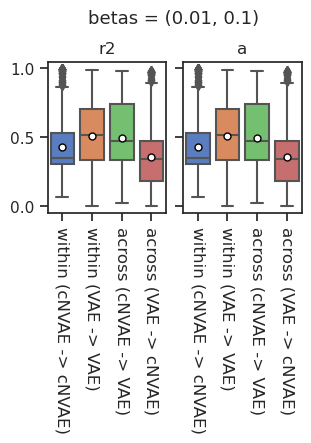

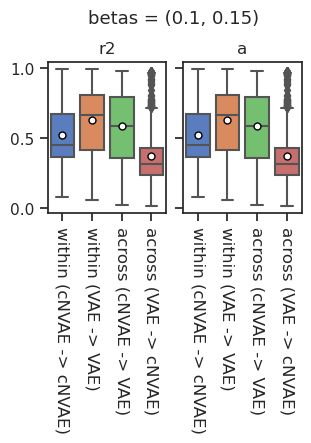

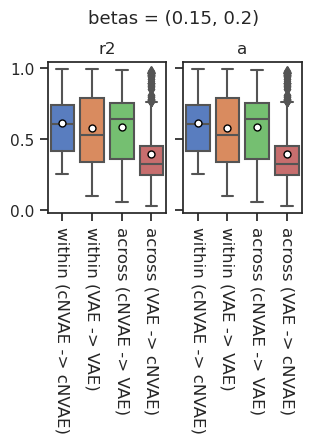

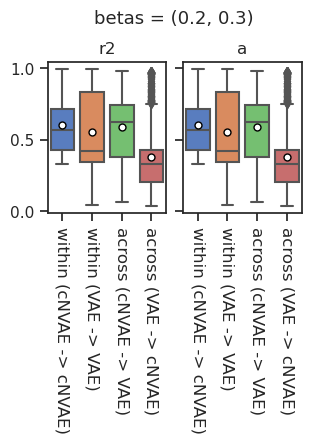

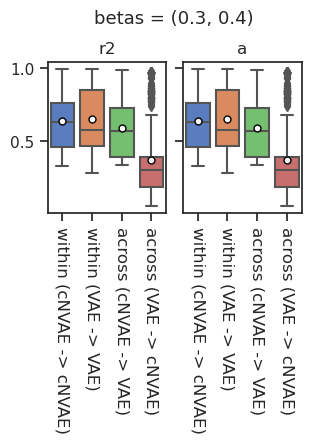

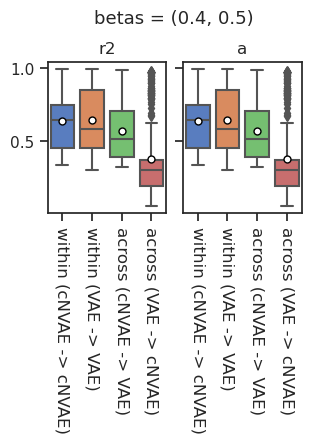

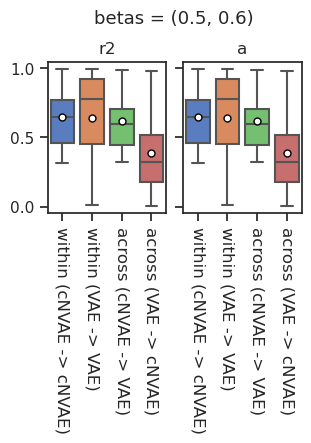

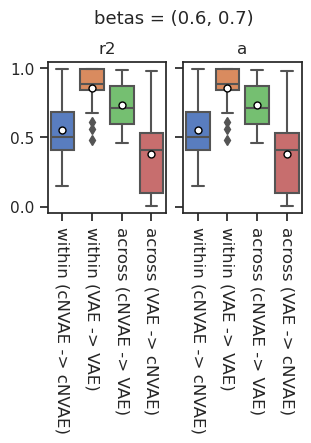

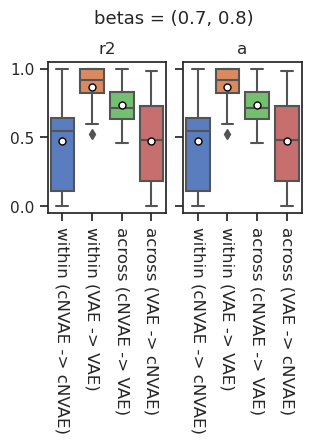

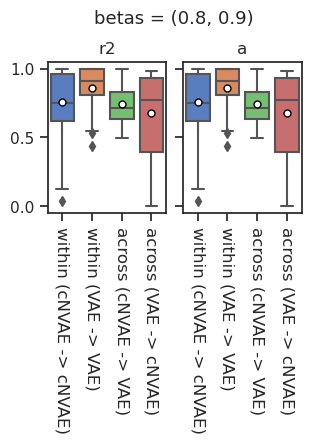

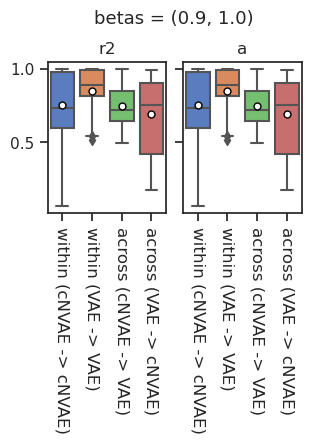

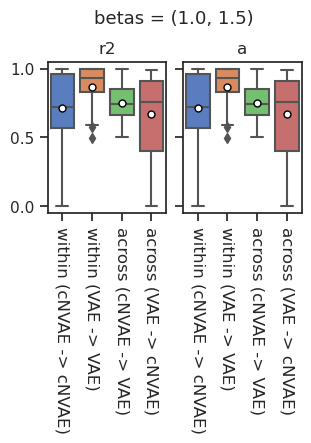

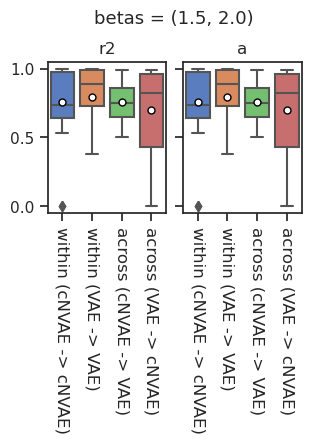

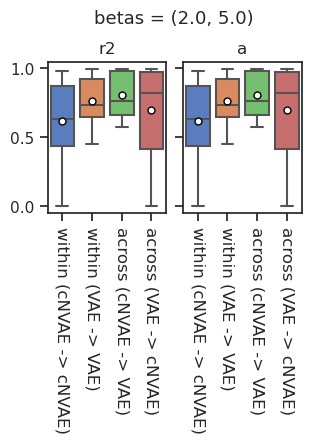

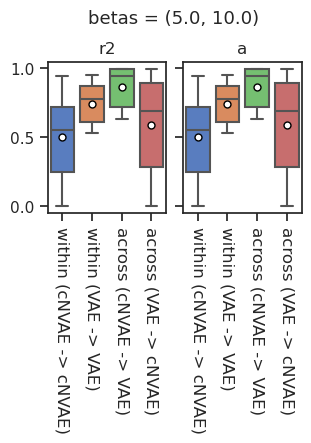

In [237]:
mod_pair = ('cNVAE', 'VAE')
for i in range(len(betas) - 1):
    beta_pair = (betas[i], betas[i + 1])
    d2p = _get_d2p(*mod_pair, beta_pair)
    fig, axes = _show(d2p, display=False)
    fig.suptitle(f"betas = {beta_pair}", fontsize=13, x=0.56, y=1.07)
    display(fig)

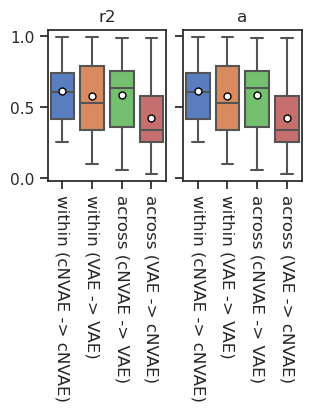

In [234]:
mod_pair = ('cNVAE', 'VAE')
beta_pair = (0.15, 0.2)

d2p = _get_d2p(*mod_pair, beta_pair)
fig, axes = _show(d2p)

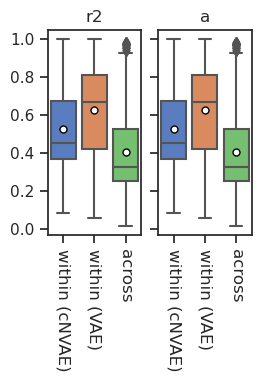

In [204]:
mod_pair = ('cNVAE', 'VAE')
beta_pair = (0.10, 0.15)

fig, axes = _show(_get_d2p(mod_pair, beta_pair))

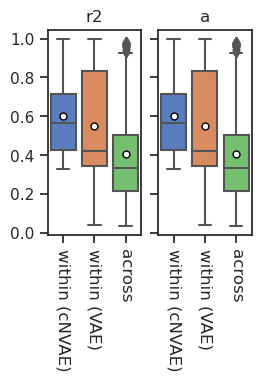

In [205]:
mod_pair = ('cNVAE', 'VAE')
beta_pair = (0.2, 0.3)

fig, axes = _show(_get_d2p(mod_pair, beta_pair))

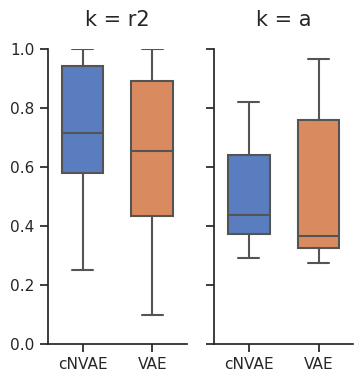

In [136]:
_pal = {
    m: pal_model.get(m) for
    m in ['cNVAE', 'VAE']
}
fg = sns.catplot(
    data=d2p.loc[d2p['cond'] == 'within'],
    col='k',
    x='model',
    y='v',
    hue='model',
    palette=_pal,
    order=_pal,
    legend='auto',
    legend_out=True,
    height=4,
    aspect=0.5,
    kind='box',
    dodge=False,
    width=0.6,
)
fg.axes[0, 0].set(ylim=(0, 1), ylabel='')
for ax in fg.axes.ravel():
    t = ax.get_title()
    t = t.replace(' | ', '\n')
    ax.set_title(t, fontsize=15, y=1.05)
    ax.set_xlabel('')
plt.show()

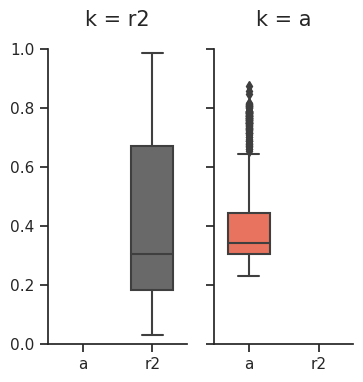

In [137]:
_pal = {'a': 'tomato', 'r2': 'dimgrey'}
fg = sns.catplot(
    data=d2p.loc[d2p['cond'] == 'across'],
    col='k',
    x='k',
    y='v',
    hue='k',
    palette=_pal,
    order=_pal,
    legend='auto',
    legend_out=True,
    height=4,
    aspect=0.5,
    kind='box',
    dodge=False,
    width=0.6,
)
fg.axes[0, 0].set(ylim=(0, 1), ylabel='')
for ax in fg.axes.ravel():
    t = ax.get_title()
    t = t.replace(' | ', '\n')
    ax.set_title(t, fontsize=15, y=1.05)
    ax.set_xlabel('')
plt.show()

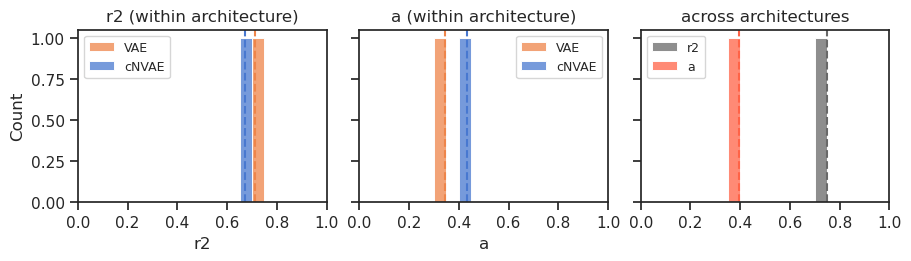

In [28]:
fig, axes = create_figure(1, 3, (9, 2.5), 'all', 'all', 'constrained')
for i, k in enumerate(['r2', 'a']):
    for mod in ['VAE', 'cNVAE']:
        _df_within = df_median.loc[
            (df_median['src'] == mod) &
            (df_median['tgt'] == mod) &
            (df_median['beta_src'] == 0.15) &
            (df_median['beta_tgt'] == 0.20)
        ]
        x2p = _df_within[k]
        sns.histplot(
            x2p,
            color=pal_model[mod],
            bins=np.linspace(0, 1, 21),
            label=mod,
            ax=axes[i],
        )
        axes[i].axvline(x2p.mean(), color=pal_model[mod], ls='--')
        axes[i].set_title(f"{k} (within architecture)")
        axes[i].legend(fontsize=9)

_df_across = df_median.loc[
    (df_median['src'] == 'cNVAE') &
    (df_median['tgt'] == 'VAE') &
    (df_median['beta_src'] == 0.15) &
    (df_median['beta_tgt'] == 0.20)
]
for k, c in [('r2', 'dimgrey'), ('a', 'tomato')]:
    x2p = _df_across[k]
    sns.histplot(
        x2p,
        color=c,
        label=k,
        bins=np.linspace(0, 1, 21),
        ax=axes[-1],
    )
    axes[-1].axvline(x2p.mean(), color=c, ls='--')
axes[-1].set_title('across architectures')
axes[-1].legend(fontsize=9)
axes[-1].set_xlim(0, 1)
axes[-1].set_xlabel('')
plt.show()

## cNVAE vs. cNVAE

In [17]:
f1 = 'fixate1_nf-420_beta-0.9_(2023_05_07,05:51).npy'
f2 = 'fixate1_nf-420_beta-1.0_(2023_04_29,19:41).npy'
x_vld, y_vld = z_vld[f1], z_vld[f2]
x_tst, y_tst = z_tst[f1], z_tst[f2]

x_active = kl_diag[f1] > thres
y_active = kl_diag[f2] > thres
x_active.sum(), y_active.sum()

(13, 17)

### zscore?

In [5]:
x_mu, x_sd = x_vld.mean(0, keepdims=True), x_vld.std(0, keepdims=True)
y_mu, y_sd = y_vld.mean(0, keepdims=True), y_vld.std(0, keepdims=True)

x_vld = normalize_global(x_vld, x_mu, x_sd)
x_tst = normalize_global(x_tst, x_mu, x_sd)

y_vld = normalize_global(y_vld, y_mu, y_sd)
y_tst = normalize_global(y_tst, y_mu, y_sd)

In [6]:
list(zip(x_mu[0, x_active], x_sd[0, x_active]))

[(10.9228325, 0.0034539725),
 (1.2925807, 11.253091),
 (1.4717253, 2.4600735),
 (1.1433208, 22.577755),
 (0.11405279, 23.527708),
 (0.34474313, 19.828737),
 (0.33880973, 17.606865),
 (-0.104978874, 13.026103),
 (0.03299829, 11.929558),
 (-0.03312666, 11.03442),
 (-0.0653676, 11.147402),
 (-0.0674578, 6.726724),
 (0.088772036, 4.75526)]

In [7]:
list(zip(y_mu[0, y_active], y_sd[0, y_active]))

[(-0.005004815, 0.79182017),
 (0.07065298, 1.3051615),
 (0.26179007, 0.38478315),
 (-0.24238503, 34.737404),
 (13.093467, 10.493587),
 (2.8949993, 31.544039),
 (-0.44077933, 33.955654),
 (0.12114962, 48.914455),
 (-0.47191173, 26.270683),
 (-0.51305187, 26.064564),
 (-0.1677357, 13.249663),
 (0.100134954, 3.1889513),
 (1.6145816, 26.434069),
 (0.027111245, 22.620485),
 (-0.10383753, 15.6840515),
 (-0.024217783, 12.807361),
 (0.13979107, 3.402484)]

In [8]:
np.where(x_active)[0], np.where(y_active)[0]

(array([ 60, 127, 154, 213, 236, 245, 272, 290, 336, 349, 366, 386, 413]),
 array([  2,  20,  45, 139, 146, 185, 220, 243, 257, 272, 290, 311, 316,
        336, 357, 370, 413]))

In [9]:
np.round(x_vld.mean(0)[x_active], 1), np.round(x_tst.mean(0)[x_active], 1)

(array([-0.9, -0. , -0. ,  0. , -0. , -0. ,  0. , -0. ,  0. , -0. ,  0. ,
        -0. , -0. ], dtype=float32),
 array([-0.9, -0. , -0. , -0. ,  0. , -0. ,  0. ,  0. , -0. ,  0. ,  0. ,
         0. , -0. ], dtype=float32))

In [10]:
np.round(y_vld.mean(0)[y_active], 1), np.round(y_tst.mean(0)[y_active], 1)

(array([ 0.,  0., -0.,  0.,  0., -0.,  0., -0.,  0., -0.,  0., -0.,  0.,
        -0., -0.,  0.,  0.], dtype=float32),
 array([ 0., -0.,  0.,  0.,  0., -0., -0., -0., -0.,  0.,  0.,  0., -0.,
        -0., -0., -0., -0.], dtype=float32))

In [11]:
%%time

lasso = sk_linear.Lasso(
    alpha=0.02,
    random_state=0,
).fit(x_vld, y_vld[:, y_active])

CPU times: user 9min 2s, sys: 1.71 s, total: 9min 4s
Wall time: 29.6 s


In [12]:
pred = lasso.predict(x_tst)

r = 1 - sp_dist.cdist(
    XA=pred.T,
    XB=y_tst[:, y_active].T,
    metric='correlation',
)
r2 = sk_metric.r2_score(
    y_pred=pred,
    y_true=y_tst[:, y_active],
    multioutput='raw_values',
)
r2.mean()

0.8644936249853196

In [15]:
w = np.abs(lasso.coef_)
w.shape

(17, 420)

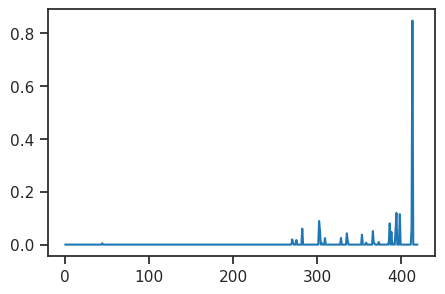

In [16]:
plt.plot(w[16])

In [17]:
from analysis.linear import compute_dci

In [18]:
d, c = compute_dci(w)
d, c

(0.7384311, 0.6046756)

In [19]:
a = 1 - entropy_normalized(w, axis=1)

In [20]:
a.shape

(17,)

In [21]:
a

array([0.51980054, 0.5071207 , 0.48669797, 0.46676618, 0.49387693,
       0.7546047 , 0.6341338 , 0.76929235, 0.71435153, 0.70017445,
       0.5991161 , 0.5486815 , 0.6468854 , 0.5411789 , 0.6409993 ,
       0.6258725 , 0.6299315 ], dtype=float32)

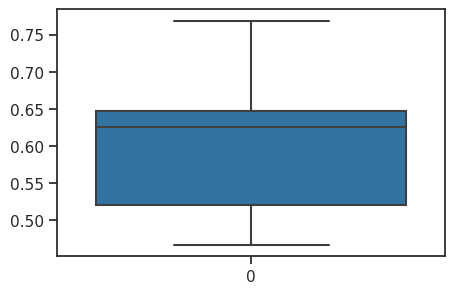

In [23]:
sns.boxplot(a);

In [24]:
np.median(a), np.mean(a)

(0.6258725, 0.6046756)

## VAE vs. VAE

In [30]:
f1 = 'vanilla_fixate1_nf-420_beta-0.9_(2023_05_13,20:45).npy'
f2 = 'vanilla_fixate1_nf-420_beta-1.0_(2023_05_07,01:18).npy'
x_vld, y_vld = z_vld[f1], z_vld[f2]
x_tst, y_tst = z_tst[f1], z_tst[f2]

thres = 1e-3
x_active = kl_diag[f1] > thres
y_active = kl_diag[f2] > thres
x_active.sum(), y_active.sum()

(6, 6)

### zscore?

In [31]:
x_mu, x_sd = x_vld.mean(0, keepdims=True), x_vld.std(0, keepdims=True)
y_mu, y_sd = y_vld.mean(0, keepdims=True), y_vld.std(0, keepdims=True)

x_vld = normalize_global(x_vld, x_mu, x_sd)
x_tst = normalize_global(x_tst, x_mu, x_sd)

y_vld = normalize_global(y_vld, y_mu, y_sd)
y_tst = normalize_global(y_tst, y_mu, y_sd)

In [32]:
list(zip(x_mu[0, x_active], x_sd[0, x_active]))

[(0.00055062195, 0.79539186),
 (0.0031704667, 0.9985981),
 (-0.0046624793, 1.003305),
 (-0.00025729055, 0.7545888),
 (-0.0064228945, 0.8589338),
 (0.007941236, 1.0024639)]

In [33]:
list(zip(y_mu[0, y_active], y_sd[0, y_active]))

[(0.0042606993, 1.000869),
 (-0.0060058055, 0.9988035),
 (0.008227088, 0.8725992),
 (0.006092067, 0.7681422),
 (-0.003597806, 1.0003748),
 (0.0019306749, 0.7283047)]

In [34]:
np.where(x_active)[0], np.where(y_active)[0]

(array([ 21,  70, 151, 262, 292, 315]), array([ 51,  86, 283, 316, 317, 413]))

In [35]:
np.round(x_vld.mean(0)[x_active], 1), np.round(x_tst.mean(0)[x_active], 1)

(array([ 0., -0., -0.,  0., -0., -0.], dtype=float32),
 array([ 0., -0.,  0., -0.,  0., -0.], dtype=float32))

In [36]:
np.round(y_vld.mean(0)[y_active], 1), np.round(y_tst.mean(0)[y_active], 1)

(array([ 0., -0., -0., -0., -0., -0.], dtype=float32),
 array([-0.,  0., -0., -0.,  0., -0.], dtype=float32))

In [37]:
%%time

lasso = sk_linear.Lasso(
    alpha=0.02,
    random_state=0,
).fit(x_vld, y_vld[:, y_active])

CPU times: user 33.4 s, sys: 232 ms, total: 33.7 s
Wall time: 2.25 s


In [38]:
pred = lasso.predict(x_tst)

r = 1 - sp_dist.cdist(
    XA=pred.T,
    XB=y_tst[:, y_active].T,
    metric='correlation',
)
r2 = sk_metric.r2_score(
    y_pred=pred,
    y_true=y_tst[:, y_active],
    multioutput='raw_values',
)
r2.mean()

0.9377286456016242

In [39]:
np.median(r2)

0.9476974158052032

In [40]:
w = np.abs(lasso.coef_)
w.shape

(6, 420)

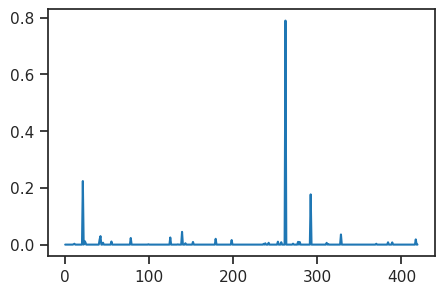

In [42]:
plt.plot(w[3])

In [43]:
from analysis.linear import compute_dci

In [44]:
d, c = compute_dci(w)
d, c

(0.6954806, 0.7640411)

In [45]:
a = 1 - entropy_normalized(w, axis=1)

In [46]:
a.shape

(6,)

In [47]:
a

array([1.        , 0.89184576, 0.5812521 , 0.6764972 , 0.8920851 ,
       0.54256606], dtype=float32)

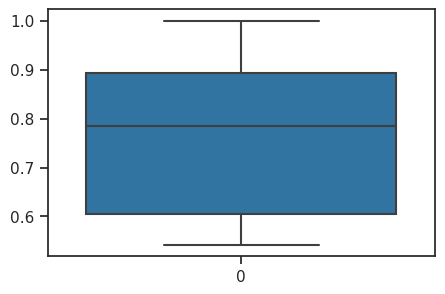

In [48]:
sns.boxplot(a);

In [49]:
np.median(a)

0.78417146